**Table of contents**<a id='toc0_'></a>    
- [Cleaned Analysis of July 6th 2023 Flight at 100 Hz](#toc1_)    
  - [Purpose:](#toc1_1_)    
  - [Methods:](#toc1_2_)    
  - [Results](#toc1_3_)    
  - [Naming and Folders](#toc1_4_)    
  - [Importing Packages and Libraries](#toc1_5_)    
  - [Importing Data](#toc1_6_)    
  - [Defining Vehicle Parameters](#toc1_7_)    
  - [Manually Selecting Mask by Plots](#toc1_8_)    
    - [Results of Manual Segmentation](#toc1_8_1_)    
      - [Cruise Segmentation](#toc1_8_1_1_)    
        - [Checking Segments for Good Data](#toc1_8_1_1_1_)    
  - [Main Analysis](#toc1_9_)    
    - [Methods:](#toc1_9_1_)    
    - [Collecting Averages and Standard Deviations from Segments](#toc1_9_2_)    
    - [Collecting Total Data-points from Segments](#toc1_9_3_)    
  - [Collecting Data into Bins](#toc1_10_)    
  - [Plotting Results of Bin and Segments](#toc1_11_)    
  - [Performing Curve Fits to Find Polars](#toc1_12_)    
  - [Packaging the Results](#toc1_13_)    
  - [Saving Results to Disk](#toc1_14_)    
  - [Additional Plots](#toc1_15_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Cleaned Analysis of July 6th 2023 Flight at 100 Hz](#toc0_)

## <a id='toc1_1_'></a>[Purpose:](#toc0_)
* Use more up to date code to run analysis
* Make sure the same equations are being used as for other analysis

## <a id='toc1_2_'></a>[Methods:](#toc0_)
Both the cruise and glides methods can be applied to this data-set

## <a id='toc1_3_'></a>[Results](#toc0_)
Glide methods are offset from the cruise methods.  Overall the cruise data is very consistent, and is better than the June 13th data.  

## <a id='toc1_4_'></a>[Naming and Folders](#toc0_)

In [1]:
### Definining name of analysis ###
name = '2023-07-06_CREATeV_Cruise_Analysis_Cleaned_MS4525'
data_path = '../../data/'
data_folder = 'createv-2023-07-06'
file_name = '00000012.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

## <a id='toc1_5_'></a>[Importing Packages and Libraries](#toc0_)

In [2]:
from os import sys
import os
sys.path.append('../../')

%matplotlib widget

from matplotlib import pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

## Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
if not os.path.exists(data_path+data_folder):
    os.makedirs(data_path+data_folder)

# Setting Plot Defaults
plt.style.use('../../basic_plotter.mplstyle')

## <a id='toc1_6_'></a>[Importing Data](#toc0_)

In [3]:
# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "CREATeV_2023"
df = main.data_load(data_path, data_folder, file_name, rate, interpolateM, processor)

## <a id='toc1_7_'></a>[Defining Vehicle Parameters](#toc0_)

In [4]:
# Vehicle parameters
prop = propellers.aeronaut20x8() # Using aeronaut 18.5 x 12
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.5020 # Mass adjusted for new propeller
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

## <a id='toc1_8_'></a>[Manually Selecting Mask by Plots](#toc0_)

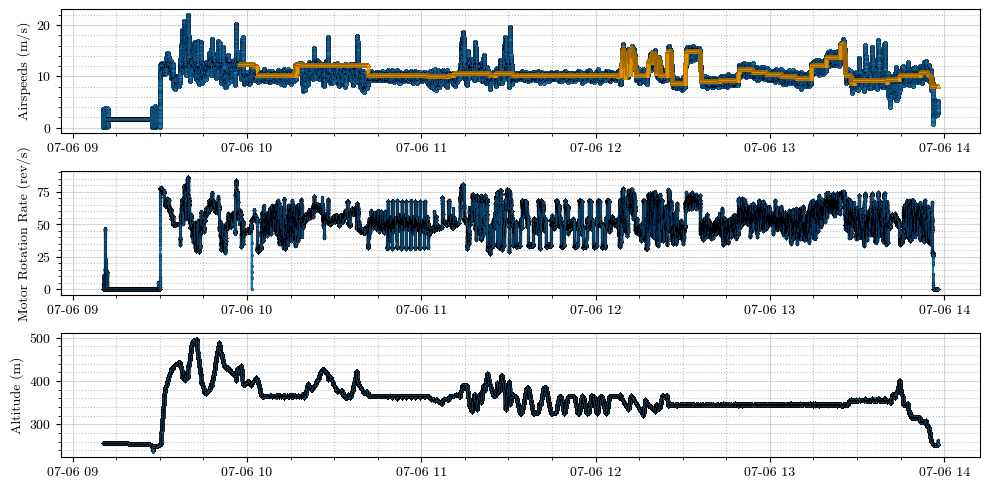

In [5]:
# Plotting Airspeed for Establishing Cruising Time Intervals
timeindex_v_rpm_h = plt.figure(figsize=(10,5), dpi=100)
ax1 = plt.subplot(3,1,1)
ax1.plot(df.index, df.Airspeed_Sensor0, label="Airspeed", marker='o', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.1)
ax1.plot(df.index, df.Airspeed_Demanded, label="Demanded Airspeed", color='orange', marker='^', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.05)
ax1.set_ylabel("Airspeeds (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
#plt.legend()

ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(df.index, df.MotorRPM/60, label='ESC Measurement')
ax2.set_ylabel("Motor Rotation Rate (rev/s)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
#plt.legend()

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(df.index, df.Altitude_POS, label='Altitude')
ax3.set_ylabel("Altitude (m)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
#plt.legend()

plt.show()
main.save_figure(timeindex_v_rpm_h, f'{timeindex_v_rpm_h=}'.split('=')[0], figure_path)

### <a id='toc1_8_1_'></a>[Results of Manual Segmentation](#toc0_)

#### <a id='toc1_8_1_1_'></a>[Cruise Segmentation](#toc0_)

In [6]:
year = 2023
month = 7
day = 6

seg_times = np.array([['12:25:00', '12:25:47'],
                        ['12:26:35', '12:30:47'],
                        ['12:31:13', '12:35:47'],
                        ['12:36:37', '12:42:27'],
                        ['12:42:30', '12:45:22'],
                        ['12:49:30', '12:54:08'],
                        ['12:54:17', '12:59:08'],
                        ['12:59:19', '13:04:08'],
                        ['13:04:13', '13:09:08'],
                        ['13:09:12', '13:14:08'],
                        ['13:14:21', '13:19:08'],
                        ['13:19:15', '13:24:08'],
                        ['13:24:23', '13:25:29']])

masks = cl_finders.get_maskarray(df, seg_times, year, month, day)

##### <a id='toc1_8_1_1_1_'></a>[Checking Segments for Good Data](#toc0_)

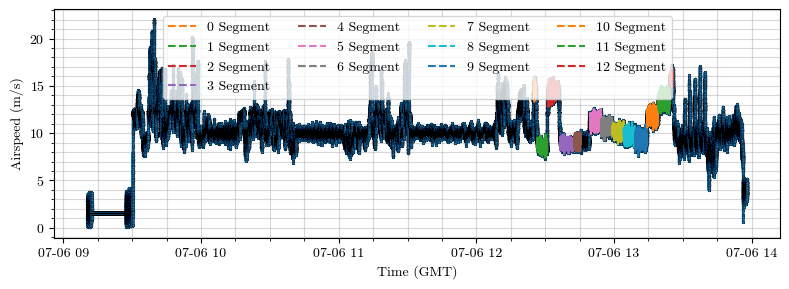

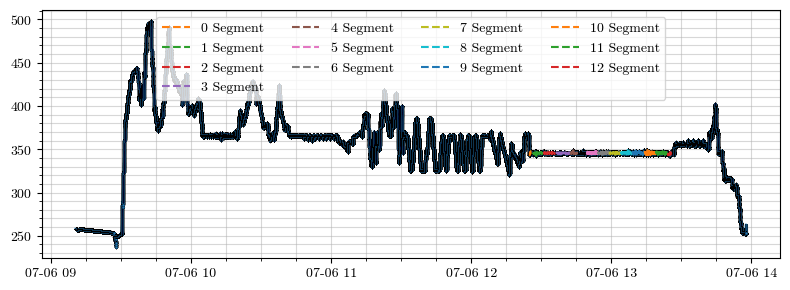

In [7]:
# Airspeed for Segments
timeindex_v_segmented = plt.figure(figsize=(8,3), dpi=100)
plt.plot(df.index, df.Airspeed_Sensor0)
for i in np.arange(len(masks)):
    plt.plot(df.Airspeed_Sensor0[masks[i]], marker='', linestyle='--', label=str(i) + " Segment")
plt.ylabel("Airspeed (m/s)")
plt.xlabel("Time (GMT)")
plt.legend(loc='upper center',
          ncol=4, fancybox=True)
plt.tight_layout()
plt.show()
main.save_figure(timeindex_v_segmented, f'{timeindex_v_segmented=}'.split('=')[0], figure_path)

# Altitude for Segments
timeindex_h_segmented = plt.figure(figsize=(8,3), dpi=100)
plt.plot(df.index, df.Altitude_POS)
for i in np.arange(len(masks)):
    plt.plot(df.Altitude_POS[masks[i]], marker='', linestyle='--', label=str(i) + " Segment")
plt.legend(loc='upper center',
          ncol=4, fancybox=True)
plt.tight_layout()
plt.show()
main.save_figure(timeindex_h_segmented, f'{timeindex_h_segmented=}'.split('=')[0], figure_path)

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


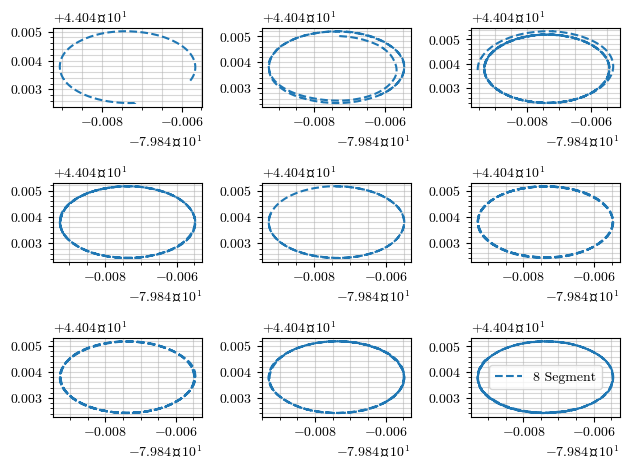

In [8]:
fig, axs = plt.subplots(3, 3)
axs = axs.flatten()
for i in np.arange(0,9):
    axs[i].plot(df.Longitude[masks[i]], df.Latitude[masks[i]], marker='', linestyle='--', label=str(i) + " Segment")
plt.legend()
plt.show()

## <a id='toc1_9_'></a>[Main Analysis](#toc0_)

### <a id='toc1_9_1_'></a>[Methods:](#toc0_)
1. Cruise Thrust Method
2. Cruise efficiency Method

In [9]:
############# Main Analysis ###############3
# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians

# Atmospheric adjustments:
rho = df["Pressure_BARO0"].to_numpy() * (287 * (df["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df["DescentRate"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"].to_numpy()
v_esc = df["EscVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power (New Fitting)
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)

P_ct_p = P_eta + (createv.weight * Vd_tas)

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_83886/4007476143.py:6: RuntimeWarning: invalid value encountered in reciprocal
  rho = df["Pressure_BARO0"].to_numpy() * (287 * (df["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_83886/4007476143.py:8: RuntimeWarning: invalid value encountered in reciprocal
  v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_83886/4007476143.py:14: RuntimeWarning: invalid value encountered in reciprocal
  Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_83886/4007476143.py:20: RuntimeWarning: divide by zero encountered in true_divide
  J = v_tas / (n * prop.diameter)
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/21_

### <a id='toc1_9_2_'></a>[Collecting Averages and Standard Deviations from Segments](#toc0_)

In [10]:
[cl_means_eta, cl_stds_eta, cl_ci95s_eta, cd_means_eta, cd_stds_eta, cd_ci95s_eta] = cl_finders.collect_segments(masks, CL, Cd_eta)
[cl_means_ct, cl_stds_ct, cl_ci95s_ct, cd_means_ct, cd_stds_ct, cd_ci95s_ct] = cl_finders.collect_segments(masks, CL, Cd_ct)

### <a id='toc1_9_3_'></a>[Collecting Total Data-points from Segments](#toc0_)

In [11]:
# Totalling up CL, CD for Cruise
cl_total_cruise = cl_finders.total_segments_boolean(CL, masks)
cd_total_eta = cl_finders.total_segments_boolean(Cd_eta, masks)
cd_total_ct = cl_finders.total_segments_boolean(Cd_ct, masks)

## <a id='toc1_10_'></a>[Collecting Data into Bins](#toc0_)

In [12]:
bins = np.linspace(0.05, 1.1, 51)
[cl_means_eta_bin, cl_stds_eta_bin, cl_ci95s_eta_bin, cd_means_eta_bin, cd_stds_eta_bin, cd_ci95s_eta_bin] = cl_finders.collect_bins(bins, cl_total_cruise, cd_total_eta)
[cl_means_ct_bin, cl_stds_ct_bin, cl_ci95s_ct_bin, cd_means_ct_bin, cd_stds_ct_bin, cd_ci95s_ct_bin] = cl_finders.collect_bins(bins, cl_total_cruise, cd_total_ct)

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/21_Cleaned_CREATeV_Performance_Analysis_MS4525/../../cl_finders.py:415: RuntimeWarning: Mean of empty slice.
  cl_means = [total_lift_coeffs[digitized == i].mean() for i in range(1, len(bins))]
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/williamkemp/opt/anaconda3/envs/superwake-record

## <a id='toc1_11_'></a>[Plotting Results of Bin and Segments](#toc0_)

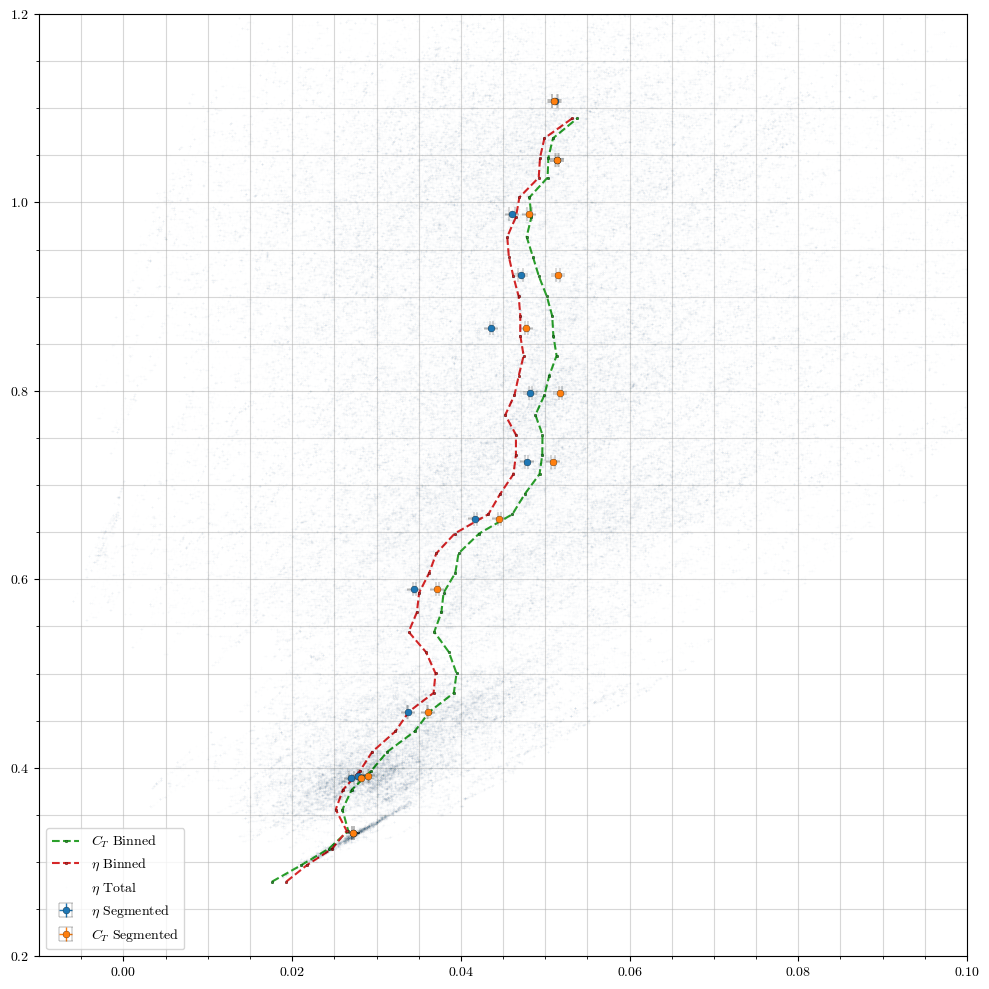

In [13]:
CruiseDescPolar_RawANDsegmented = plt.figure(figsize=(10,10), dpi=100)
plt.errorbar(cd_means_eta, cl_means_eta, xerr=cd_ci95s_eta, yerr=cl_ci95s_eta, linestyle='', markersize = 10, capsize=5, elinewidth=1, label="$\eta$ Segmented")
plt.errorbar(cd_means_ct, cl_means_ct, xerr=cd_ci95s_ct, yerr=cl_ci95s_ct, linestyle='', markersize = 10, capsize=5, elinewidth=1, label="$C_T$ Segmented")

plt.plot(cd_means_ct_bin, cl_means_ct_bin, linestyle='--', label="$C_T$ Binned")
plt.plot(cd_means_eta_bin, cl_means_eta_bin, linestyle='--', label="$\eta$ Binned")


plt.plot(cd_total_ct, cl_total_cruise, linestyle='', color="C{}".format(0), alpha=0.01, marker='.', markersize=2, label="$\eta$ Total")
plt.xlim([-0.01, 0.1])
plt.ylim([0.2, 1.2])
plt.legend()
plt.show()
main.save_figure(CruiseDescPolar_RawANDsegmented, f'{CruiseDescPolar_RawANDsegmented=}'.split('=')[0], figure_path, overwrite=True)

## <a id='toc1_12_'></a>[Performing Curve Fits to Find Polars](#toc0_)

In [14]:
polar_eta = cl_finders.cd2polar(createv, cd_means_eta, cl_means_eta, highorder=False)
polar_ct = cl_finders.cd2polar(createv, cd_means_ct, cl_means_ct, highorder=False)

polar_eta_bin = cl_finders.cd2polar(createv, cd_means_eta_bin, cl_means_eta_bin, highorder=False)
polar_ct_bin = cl_finders.cd2polar(createv, cd_means_ct_bin, cl_means_ct_bin, highorder=False)

print(polar_eta)
print(polar_ct)

print(polar_eta_bin)
print(polar_ct_bin)

0.671035769464442
0.627630118751602
0.6199040926608135
0.5819005310808371
[0.02794719 0.91214106]
[0.03008879 0.91431118]
[0.02701444 0.83685392]
[0.0287547  0.80735873]


## <a id='toc1_13_'></a>[Packaging the Results](#toc0_)

In [15]:
eta_cruise_segresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_eta, cl_stds_eta, cl_ci95s_eta, cd_total_eta, cd_means_eta, cd_stds_eta, cd_ci95s_eta, polar_eta, createv)
ct_cruise_segresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_ct, cl_stds_ct, cl_ci95s_ct, cd_total_ct, cd_means_ct, cd_stds_ct, cd_ci95s_ct, polar_ct, createv)

eta_cruise_binresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_eta_bin, cl_stds_eta_bin, cl_ci95s_eta_bin, cd_total_eta, cd_means_eta_bin, cd_stds_eta_bin, cd_ci95s_eta_bin, polar_eta_bin, createv)
ct_cruise_binresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_ct_bin, cl_stds_ct_bin, cl_ci95s_ct_bin, cd_total_ct, cd_means_ct_bin, cd_stds_ct_bin, cd_ci95s_ct_bin, polar_ct_bin, createv)


## <a id='toc1_14_'></a>[Saving Results to Disk](#toc0_)

In [16]:
# Saving results to their pickles
pd.to_pickle(eta_cruise_segresult, result_path+'eta_cruise_segresult.pkl')
pd.to_pickle(ct_cruise_segresult, result_path+'ct_cruise_segresult.pkl')

pd.to_pickle(eta_cruise_binresult, result_path+'eta_cruise_binresult.pkl')
pd.to_pickle(ct_cruise_binresult, result_path+'ct_cruise_binresult.pkl')

## <a id='toc1_15_'></a>[Additional Plots](#toc0_)

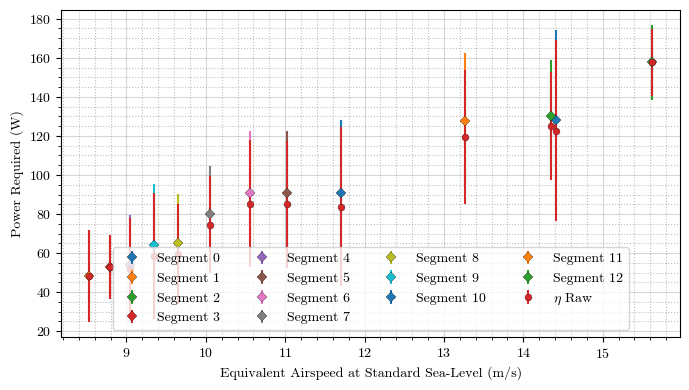

In [17]:
# Plot of Power Required Fits and Data #

[Pave_ct, EAS_Ct] = cl_finders.rawpolar2preqew(createv, cl_means_ct, cd_means_ct)
[Pave_eta, EAS_eta] = cl_finders.rawpolar2preqew(createv, cl_means_eta, cd_means_eta)

CTPolar_SegmentedwBadData = plt.figure(figsize=(7,4), dpi=100)
for i in range(len(masks)):
    plt.errorbar(EAS_Ct[i], Pave_ct[i], yerr=cd_stds_ct[i]*0.5*1.225*createv.area*EAS_Ct[i]**3 , label="Segment "+str(i), linestyle='', marker='D', markersize=5)
plt.errorbar(EAS_eta, Pave_eta, yerr=cd_stds_eta*0.5*1.225*createv.area*EAS_eta**3 , label="$\eta$ Raw", linestyle='', marker='o', markersize=5)

plt.xlabel("Equivalent Airspeed at Standard Sea-Level (m/s)")
plt.ylabel("Power Required (W)")
plt.legend(loc='lower center', ncol=4)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.tight_layout()
plt.show()
main.save_figure(CTPolar_SegmentedwBadData, f'{CTPolar_SegmentedwBadData=}'.split('=')[0], figure_path, overwrite=True)

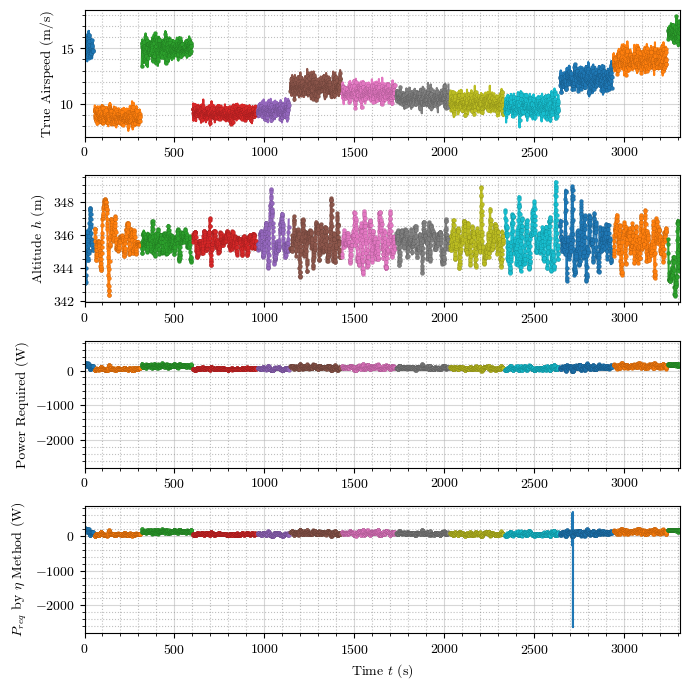

In [18]:
# Plotting Steady-level Data Runs #
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
timeindex_v_h_Pct_Peta = plt.figure(figsize=(7,7))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax1.plot(time_s, v_tas[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax0.plot(time_s, h[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("Altitude $h$ (m)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax2.plot(time_s, P_ct[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("Power Required (W)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(4,1,4, sharex=ax1, sharey=ax2)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax3.plot(time_s, P_eta[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$P_{req}$ by $\eta$ Method (W)")
ax3.set_xlabel("Time $t$ (s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()
main.save_figure(timeindex_v_h_Pct_Peta, f'{timeindex_v_h_Pct_Peta=}'.split('=')[0], figure_path)